In [2]:
try:
  import distrax
except ModuleNotFoundError:
  %pip install distrax
  import distrax
try:
  import jax
except ModuleNotFoundError:
  %pip install jax 
  import jax

import jax.numpy as jnp
try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  %pip install matplotlib 
  import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)

In [3]:
def data(num_points, test_points, key_, noise):

  X =  jnp.linspace(-4, 4, num_points).reshape(-1,1) 
  y = jnp.sin(X)

  test_points = 100
  X_test =  jnp.linspace(-5, 5, test_points).reshape(-1,1) 
  y_test = jnp.sin(X_test)

  if (noise):
    y = y + jax.random.normal(key = key_, shape = (num_points, 1)) * noise**0.5
    y_test = y_test + jax.random.normal(key = key_, shape = (test_points, 1)) * noise**0.5

  return X, y , X_test, y_test

In [97]:
def prior_samples(X_test, key, test_points):

  def rbf(x, x_star, len_scale, sigmaf):
    return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

  Kstar_star = rbf(X_test, X_test.T, 0.1, 1)
  mean_vec = jnp.zeros(X_test.shape[0])
  print(Kstar_star.shape, mean_vec.shape)
  prior = distrax.MultivariateNormalFullCovariance(mean_vec,jnp.sqrt(Kstar_star))
  f_prior = prior.sample(seed=key, sample_shape = (10,))

  return f_prior

(100, 100) (100,)


Text(0.5, 1.0, '10 prior samples ')

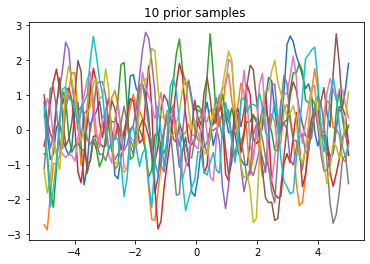

In [98]:

## Noiseless Data
X, y, X_test, y_test = data(7, 100, key, noise = 0)
f_prior = prior_samples(X_test, key, 100)
fig = plt.figure()
plt.plot(X_test, f_prior.T)
plt.title("10 prior samples ")
# plt.savefig('prior_sample.png')

In [101]:
class GP_Regression:
  
  def __init__(self, len_scale, sigmaf):
    self.len_scale = len_scale
    self.sigmaf = sigmaf

  def rbf(self, x, x_star, len_scale, sigmaf):
    return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

    
  def periodic_kernel(self, x, xstar, len_scale, sigmaf, period):
    return (sigmaf**2)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))

  def posterior(self, X, y, X_test, mu_prior, sigmay):
    k = self.rbf(X,X.T,self.len_scale, self.sigmaf)
    k = k + (sigmay * jnp.eye(len(X)))
    L = jnp.linalg.cholesky(k)
    kstar = self.rbf(X, X_test.T, self.len_scale, self.sigmaf)
    kstar_star = self.rbf(X_test, X_test.T, self.len_scale, self.sigmaf)

    # posterior mean
    alpha = jnp.linalg.solve(L.T, (jnp.linalg.solve(L, (y - mu_prior))))
    self.mu_posterior =  mu_prior + jnp.dot(kstar.T, alpha)

    # posterior covarinace
    v = jnp.linalg.solve(L, kstar)
    self.cov_posterior = kstar_star - jnp.dot(v.T, v)

    return self.mu_posterior, self.cov_posterior


  def posterior_samples(self, key, test_points, samples):
    # prior mean equal to zero
    # f_post = self.mu_posterior.reshape(-1,1) + jnp.dot(self.cov_posterior, jax.random.normal(key = key, shape = (test_points, samples)))
    posterior = distrax.MultivariateNormalFullCovariance(self.mu_posterior.reshape(-1,),self.cov_posterior)
    f_post = posterior.sample(seed=key, sample_shape = (10,))
    f_post = f_post.T
    return f_post

(100, 1) (100, 100)


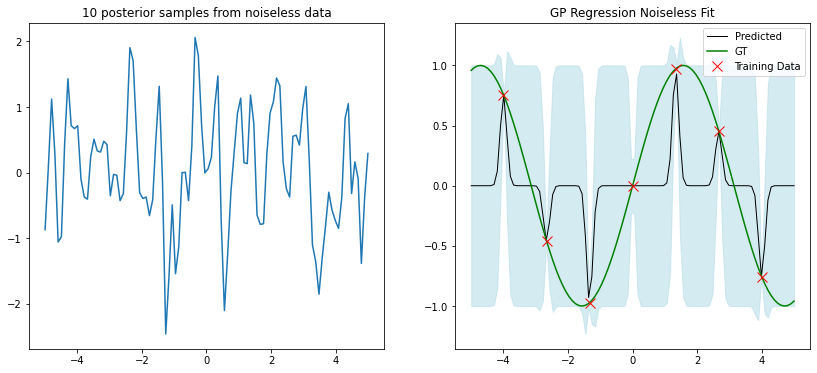

In [102]:
X, y, X_test, y_test = data(7, 100, key, noise = 0)
GPR_noiseless = GP_Regression(0.1, 1)
mu_posterior, cov_posterior = GPR_noiseless.posterior(X, y, X_test, 0, 0)


print(mu_posterior.shape, cov_posterior.shape)
fig, ax = plt.subplots(1,2,figsize=(14,6))

# 10 posterior samples
f_post = GPR_noiseless.posterior_samples(key, 100, 10)
ax[0].plot(X_test, f_post)
ax[0].set_title("10 posterior samples from noiseless data")

# plot showing mean and covaraince of 
ax[1].plot(X_test, mu_posterior,'k',label='Predicted',lw=1)
ax[1].plot(X_test, y_test, 'g',label='GT',lw=1.5)
ax[1].plot(X, y, 'x', c = 'r', markersize=10, label='Training Data')

ax[1].fill_between(X_test.flatten(), 
                 (mu_posterior.flatten() - cov_posterior.diagonal().flatten()),
                 (mu_posterior.flatten() + cov_posterior.diagonal().flatten()),
                  color='lightblue', alpha=0.5)

plt.legend()
ax[1].set_title("GP Regression Noiseless Fit")
# plt.savefig("GP_noiseless_posterior.png")
plt.show()

In [88]:
def rbf(x, x_star, len_scale, sigmaf):
  return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

def periodic_kernel(x, xstar, len_scale, sigmaf, period):
  return (sigmaf**2)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))

def nll(X,y,len_scale, sigmaf, var_y):
  k_sigma = rbf(X, X.T, len_scale, sigmaf) +  ((var_y) * jnp.eye(X.shape[0]))
  mean_vec= jnp.zeros(X.shape[0])
  dist = distrax.MultivariateNormalFullCovariance(mean_vec, k_sigma)
  dist_logprob = dist.log_prob(y.reshape(-1,))
  return -dist_logprob

In [89]:
X, y, X_test, y_test = data(7, 100, key, noise = 1.)
nll(X,y, 1.33, 1., 0.45)

DeviceArray(18.40615528, dtype=float64)

1.0 nan nan
27890 nan


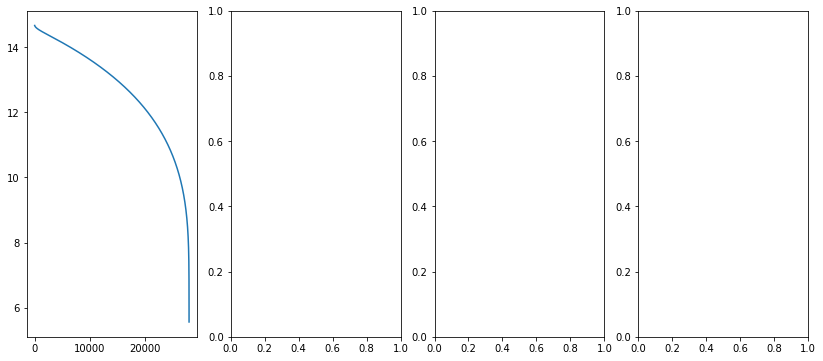

In [ ]:
# initial paramters
len_scale = 1.
sigmaf = 1.
sigmay = 1.
max_iters = int(35)
lr = 0.0001
nll_iters = []
X, y, X_test, y_test = data(7, 100, key, noise = 1)

# Trying for multiple values

len_scale_arr = [1.,0.1, 1., 2.]
sigmaf_arr = [1., 1., 3., 2.]
sigmay_arr = [1., 0.6, 0.6, 1.]

# Using jax.grad
nll_gradient = jax.grad(nll, argnums=[2,3,4])

# iterations
nll_iters_final= []
nll_iters_min = []
nll_params = []

# Using adam optimizer
from jax.experimental import optimizers
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init((len_scale, sigmaf, sigmay))


fig, ax = plt.subplots(1,4,figsize=(14,6))

for j in range(1):
  len_scale = len_scale_arr[j]
  sigmaf = sigmaf_arr[j]
  sigmay = sigmay_arr[j]
  nll_iters = []

  for i in range(max_iters):
    nll_iters.append(nll(X, y, len_scale, sigmaf, sigmay))
    grads = nll_gradient(X, y, len_scale, sigmaf, sigmay)
    opt_state = opt_update(0, grads, opt_state)
    len_Scale, sigmaf, sigmay = get_params(opt_state)

  nll_iters = jnp.array(nll_iters)
  ax[j].plot(nll_iters)
  
  print(len_scale, sigmaf, sigmay)
  print(jnp.argmin(nll_iters), nll_iters[-1])
  nll_iters_final.append(nll_iters[-1])
  nll_iters_min.append(jnp.min(nll_iters))
  nll_params.append([len_scale, sigmaf, sigmay])